In [1]:
# Tools for monitoring audio and maybe recording too
%matplotlib inline
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os
import logging

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [2]:
def make_folder(bird, sess, path_type, exp_folder = '/Volumes/gentner/earneodo/bci_zf/'):
    assert(os.path.isdir(exp_folder))
    bird_folder = os.path.join(os.path.abspath(exp_folder), path_type, bird)
    sess_folder = os.path.join(bird_folder, str(sess).zfill(3))
    logger.info('Making folder {}'.format(sess_folder))
    if not os.path.isdir(sess_folder):
        os.makedirs(sess_folder)
    return sess_folder

def today_sess():
    st = time.strptime(time.ctime())
    return "{:04d}{:02d}{:02d}".format(st.tm_year, st.tm_mon, st.tm_mday)

def dated_file_path(path_pars = None):
    if path_pars == None:
        sess_path = os.getcwd()
    else:
        try:
            sess_path = path_pars['sess_path']
        except:
            logger.warn('Wrong path_parameters (sess_path key missing)')
    
    st = time.strptime(time.ctime())
    file_name = "{:02d}{:02d}{:02d}_sound.wav".format(st.tm_hour, st.tm_min, st.tm_sec)
    return os.path.join(sess_path, file_name)

def list_devices(pa):
    for i in range(pa.get_device_count()):
        print(pa.get_device_info_by_index(i))
    
def get_device_by_name(pa, name):
    all_dev = [pa.get_device_info_by_index(j) for j in range(pa.get_device_count())]
    found = [d for d in all_dev if d['name']==name]
    if len(found) > 1:
        raise ValueError('Found duplicated name devices')
    if len(found) == 0:
        raise ValueError('Not found device named {}'.format(name))
    return found[0]


def unpack_bits(stream, dtype='<h', n_chans=1):
    formatted = np.fromstring(stream, dtype=np.dtype(dtype))
    return formatted

def rms(x):
    return np.linalg.norm(np.array(x, dtype=np.int64))/np.sqrt(x.size)

def mad(x):
    med = np.median(x)
    dev = np.abs(x - np.median(x))
    return np.median(dev)

def msg(string):
    print(string)
    sys.stdout.flush()

class audioBuffer:
    
    def __init__(self, dtype='<h', n_chans=1):
        self._stream = b''
        self.dtype = '<h'
        self.n_chans = n_chans

    def append(self, new_stream):
        self._stream += new_stream
    
    def write(self, new_stream):
        self._stream = new_stream
        
    def read_binary(self):
        return self._stream
    
    # size in bytes
    def get_size(self):
        return len(self._stream)
    
    def get_n_formatted(self):
        return len(self._stream) / np.zeros(1, dtype=np.dtype(self.dtype)).nbytes
    
    def clear_data(self):
        self._stream = b''
    
    def read_formatted(self):
        return unpack_bits(self._stream, self.dtype, self.n_chans)


class Recorder:
    _dev_id = 0
    _dev_name = None
    
    def __init__(self, channels=1, rate=44100, frames_per_buffer=4096, dev_id=0, dev_name=None, path_pars=None):
        self.channels = channels
        self.rate = rate
        self.sampling_step_ms = 1000./rate
        self.frames_per_buffer = frames_per_buffer
        self._pa = pyaudio.PyAudio()
        self._stream = None
        self.stream_buffer = audioBuffer(dtype='<h', n_chans = channels)
        self.wavefile = None
    
        self._is_recording = False
        self.rms_thresh = 2000.
        self.rms_stop_thresh = 1400.
        self.monitor_channel = 0
        self.monitor_buffer_size_ms = 2000
        self.monitor_buffer_max_elem = self.monitor_buffer_size_ms/self.sampling_step_ms * channels
        self.monitor_status = 'off'
        self.recorded_samples = 0
        self.record_epoch_ms = 10000 #records maximum 60 sec epochs
        self.record_epoch_max_elem = self.record_epoch_ms/self.sampling_step_ms * channels
        self.ms_in_buf = 0
        self.callback_count = 0
        
        self.record_n_samples = None
        
        self._dev_id = dev_id if dev_name is None else get_device_by_name(self._pa, dev_name)['index']
        self._dev_name = dev_name
        
        self.path_pars = path_pars
        
    def msec_to_frames(self, n_msec):
        return np.int(np.ceil(self.rate/(1000.*self.frames_per_buffer)*n_msec))
    
    
    def read_frames(self, n, msec=True):
        msg('Reading {} frames'.format(n))
        self._is_recording = True
        self.ms_in_buf = 0
        self.callback_count = 0
        
        self.record_n_samples = n*self.rate*0.001 if msec else n_frames
        msg('Collecting {} samples'.format(self.record_n_samples))
        self._stream = self._pa.open(format=pyaudio.paInt16,
                                    channels=self.channels,
                                    rate=self.rate,
                                    input=True,
                                    input_device_index = self._dev_id,
                                    frames_per_buffer=self.frames_per_buffer,
                                    stream_callback = self.get_read_callback())
        self.stream_buffer.clear_data()
        self._stream.start_stream()
        
        return self.stream_buffer
    
    def get_avg_rms(self, window_len = 3000):
        rms_buffer = self.read_frames(window_len) 
        time.sleep(window_len * 0.001)
        time.sleep(0.5)
        rms_buffer_formatted = rms_buffer.read_formatted()
        plt.plot(rms_buffer_formatted)
        return rms(rms_buffer_formatted), np.median(rms_buffer_formatted), mad(rms_buffer_formatted)
    
    def auto_thresholds(self, up_factor=2, lo_factor=1.5):
        w_rms, w_median, w_mad = self.get_avg_rms()
        self.rms_thresh = w_rms + up_factor * w_mad
        self.rms_stop_thresh = w_rms + lo_factor * w_mad
        logger.info('RMS {}'.format(w_rms))
        logger.info('Auto set up/lo thresholds to {} / {}'.format(self.rms_thresh, self.rms_stop_thresh))
        
    def start_triggered_mode(self):
        msg("starting monitoring")
        self._stream = self._pa.open(format=pyaudio.paInt16,
                            channels=self.channels,
                            rate=self.rate,
                            input=True,
                            input_device_index = self._dev_id,
                            frames_per_buffer=self.frames_per_buffer,
                            stream_callback=self.get_callback())
        
        self.stream_buffer.clear_data()
        self.monitor_status = 'armed'
        self._stream.start_stream()
        return self
    
    def stop_triggered_mode(self):
        msg('Stopping monitor: ' + self.monitor_status)
        if self.monitor_status == 'triggered':
            self.stop_triggered_recording()
            
        self._stream.stop_stream()
        self.monitor_status = 'off'
        
    def get_read_callback(self):
        def callback(in_data, frame_count, time_info, status):
            self.callback_count = self.callback_count + 1
            self.stream_buffer.append(in_data)            
            elem_in_buf = self.stream_buffer.get_n_formatted()
            # decide whether to continue or it is complete
            #msg('Elem in buf {}'.format(elem_in_buf))
            if elem_in_buf < self.record_n_samples:
                return in_data, pyaudio.paContinue
            else:
                msg('Done sampling')
                return in_data, pyaudio.paComplete
        return callback
            
    def get_callback(self):
        def callback(in_data, frame_count, time_info, status):
            
            self.callback_count = self.callback_count + 1
            self.stream_buffer.append(in_data)            
            elem_in_buf = self.stream_buffer.get_n_formatted()
            
            # Decide whether to analyze state of the machine
            if elem_in_buf > self.monitor_buffer_max_elem:
                #print "full buffer"
                #plt.plot(self.stream_buffer.read_formatted())
                #msg(str(rms(self.stream_buffer.read_formatted())))
                
                if self.monitor_status == 'armed':
                    #msg('Armed with rms ' + str(rms(self.stream_buffer.read_formatted())))
                    
                    if rms(self.stream_buffer.read_formatted()) > self.rms_thresh:
                        print('Should start recording')
                        sys.stdout.flush()
                        self.start_triggered_recording()
                        self.recorded_samples = elem_in_buf

                
                elif self.monitor_status == 'triggered':
                    msg('Triggered with rms ' + str(rms(self.stream_buffer.read_formatted())))
                    if rms(self.stream_buffer.read_formatted()) >= self.rms_stop_thresh:
                        self.continue_triggered_recording()
                        self.recorded_samples = self.recorded_samples + elem_in_buf
                        if self.recorded_samples > self.record_epoch_max_elem:
                            msg('Recording went too long, stopping it')
                            self.stop_triggered_recording()
                    else:
                        self.stop_triggered_recording()
                
                self.stream_buffer.clear_data()
            return in_data, pyaudio.paContinue
        return callback
    
    def start_triggered_recording(self):
        print("Starting to record")
        sys.stdout.flush()
        file_name = self.make_file_path()
        self._prep_file(file_name)
        self._buffer_to_file()
        self.monitor_status = 'triggered'
        
    def continue_triggered_recording(self):
        print("continuing recording")
        sys.stdout.flush()
        self._buffer_to_file()
    
    def stop_triggered_recording(self):
        print("Recording Stopped")
        self._buffer_to_file()
        self._close_file()
        self.monitor_status = 'armed'
        return self
        
    def make_file_path(self):
        return dated_file_path(self.path_pars)
    
    def _prep_file(self, file_name, mode='wb'):
        msg("preparing file " + file_name)
        self.wavefile = wave.open(file_name, mode)
        self.wavefile.setnchannels(self.channels)
        self.wavefile.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        self.wavefile.setframerate(self.rate)
        msg('file open')
    
    def _close_file(self):
        self.wavefile.close()
        
    def _buffer_to_file(self):
        # send the data to file
        print("storing data")
        self.wavefile.writeframes(self.stream_buffer.read_binary())
        #plt.plot(self.stream_buffer.read_formatted())
        self.stream_buffer.clear_data()


#moni = Recorder(dev_name='adc1')
#moni.start_triggered_mode()
#bufread = moni.read_frames(1000)

In [3]:
exp_folder = '/mnt/cube/earneodo/bci_zf/'
bird = 'b1125'
sess = today_sess()

sess_path = make_folder(bird, sess, 'raw_data', exp_folder=exp_folder)
moni = Recorder(dev_name='adc1', path_pars={'sess_path': sess_path})

2018-03-02 17:38:45,429 root         INFO     Making folder /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302


In [4]:
moni._dev_id

21

Reading 3000 frames
Done sampling


/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
2018-03-02 17:39:00,623 root         INFO     RMS 880.4753922027361
2018-03-02 17:39:00,623 root         INFO     Auto set up/lo thresholds to 2087.975392202736 / 1846.4753922027362


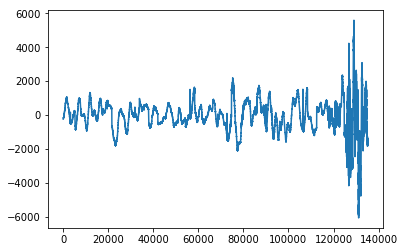

In [6]:
moni.auto_thresholds(up_factor=2.5, lo_factor=2.0)

In [35]:
moni.rms_thresh = 2000

In [7]:
moni.start_triggered_mode()

starting monitoring


/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/173923_sound.wav
file open
storing data
Triggered with rms 2987.8134372290883
continuing recording
storing data
Triggered with rms 3743.54090094684
continuing recording
storing data
Triggered with rms 3360.213556201042
continuing recording
storing data
Triggered with rms 1254.0242787306597
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/173935_sound.wav
file open
storing data
Triggered with rms 2021.2416423519942
continuing recording
storing data
Triggered with rms 1193.246157728253
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/180452_sound.wav
file open
storing data
Triggered with rms 755.1839114716338
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/ea

Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/062228_sound.wav
file open
storing data
Triggered with rms 1060.5429281223644
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/070530_sound.wav
file open
storing data
Triggered with rms 1188.1074833443608
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/072744_sound.wav
file open
storing data
Triggered with rms 792.2189600480561
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/073830_sound.wav
file open
storing data
Triggered with rms 734.4244480677747
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/

file open
storing data
Triggered with rms 782.2290438439534
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/015758_sound.wav
file open
storing data
Triggered with rms 733.5952772895928
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/022314_sound.wav
file open
storing data
Triggered with rms 1060.766836206247
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/023702_sound.wav
file open
storing data
Triggered with rms 984.7586734027653
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/030754_sound.wav
file open
storing data
Triggered with rms 757.7989744502319
Recording Stopped
storing data
Should start recording
Starting to record
prepari

Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/070648_sound.wav
file open
storing data
Triggered with rms 907.8860370889057
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/071027_sound.wav
file open
storing data
Triggered with rms 759.3747583180966
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/071031_sound.wav
file open
storing data
Triggered with rms 1519.3603959326451
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/071644_sound.wav
file open
storing data
Triggered with rms 1044.3338804051054
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/072131_sound.wav
file open
storing data
Triggered with

file open
storing data
Triggered with rms 2048.667166688557
continuing recording
storing data
Triggered with rms 1455.913253604736
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/142741_sound.wav
file open
storing data
Triggered with rms 770.2426601790813
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/143614_sound.wav
file open
storing data
Triggered with rms 1004.5434058876754
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/144809_sound.wav
file open
storing data
Triggered with rms 983.8954994948523
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/144821_sound.wav
file open
storing data
Triggered with rms 1704.7070609985633
Recordi

file open
storing data
Triggered with rms 815.4879888827211
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/065239_sound.wav
file open
storing data
Triggered with rms 811.9684206625474
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/070144_sound.wav
file open
storing data
Triggered with rms 770.8044385860431
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/070408_sound.wav
file open
storing data
Triggered with rms 841.634460457855
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/100824_sound.wav
file open
storing data
Triggered with rms 730.1078085601278
Recording Stopped
storing data
Should start recording
Starting to record
preparin

Triggered with rms 2479.759401118063
continuing recording
storing data
Triggered with rms 783.4546159361828
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135923_sound.wav
file open
storing data
Triggered with rms 6490.597501480518
continuing recording
storing data
Triggered with rms 1244.4916187941703
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135934_sound.wav
file open
storing data
Triggered with rms 1355.105694775915
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135957_sound.wav
file open
storing data
Triggered with rms 894.0364515202047
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/140002_sound.wav
file open
storing da

Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/162049_sound.wav
file open
storing data
Triggered with rms 1826.270256814559
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/162121_sound.wav
file open
storing data
Triggered with rms 856.7555335232711
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/162128_sound.wav
file open
storing data
Triggered with rms 1181.960242696122
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/162135_sound.wav
file open
storing data
Triggered with rms 1843.987978541555
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/16

file open
storing data
Triggered with rms 2309.694856594157
continuing recording
storing data
Triggered with rms 1958.9687862579929
continuing recording
storing data
Triggered with rms 1321.0954800427828
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/175143_sound.wav
file open
storing data
Triggered with rms 1324.8709390118627
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/175735_sound.wav
file open
storing data
Triggered with rms 977.1075958640135
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/180050_sound.wav
file open
storing data
Triggered with rms 838.1032351111327
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/180055_sound

file open
storing data
Triggered with rms 7192.936619483238
continuing recording
storing data
Triggered with rms 6403.461740262918
continuing recording
storing data
Triggered with rms 1733.3407510871712
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/040925_sound.wav
file open
storing data
Triggered with rms 1837.871591441511
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/040930_sound.wav
file open
storing data
Triggered with rms 2746.8603558300756
continuing recording
storing data
Triggered with rms 1032.8532473094267
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/040937_sound.wav
file open
storing data
Triggered with rms 5933.454733096238
continuing recording
storing data
Triggered with rms 5294.125907123129
continui

file open
storing data
Triggered with rms 1850.3611225476154
continuing recording
storing data
Triggered with rms 1004.3541921860009
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/042459_sound.wav
file open
storing data
Triggered with rms 1941.7207945984758
continuing recording
storing data
Triggered with rms 6168.412629569308
continuing recording
storing data
Triggered with rms 7931.908504566449
continuing recording
storing data
Triggered with rms 6351.584437151119
continuing recording
storing data
Recording went too long, stopping it
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/042510_sound.wav
file open
storing data
Triggered with rms 821.5212936887933
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/042552_sound.w

continuing recording
storing data
Triggered with rms 1727.7657135720704
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/044603_sound.wav
file open
storing data
Triggered with rms 8002.548778789742
continuing recording
storing data
Triggered with rms 926.5854023667131
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/044707_sound.wav
file open
storing data
Triggered with rms 1159.5854413284326
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/044712_sound.wav
file open
storing data
Triggered with rms 1350.0309465369055
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/045055_sound.wav
file open
storing data
Triggered with rms 1370.93898518

Triggered with rms 2366.9544042268767
continuing recording
storing data
Triggered with rms 896.9561248685393
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/051012_sound.wav
file open
storing data
Triggered with rms 2277.1690792864483
continuing recording
storing data
Triggered with rms 1304.0075026433005
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/051021_sound.wav
file open
storing data
Triggered with rms 670.223993133731
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/051121_sound.wav
file open
storing data
Triggered with rms 1538.9462504262435
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/051127_sound.wav
file open
storing 

file open
storing data
Triggered with rms 1792.093305388037
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/053933_sound.wav
file open
storing data
Triggered with rms 5718.569909973307
continuing recording
storing data
Triggered with rms 4370.814287858902
continuing recording
storing data
Triggered with rms 979.1868144448044
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/054014_sound.wav
file open
storing data
Triggered with rms 1701.300770564376
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/054023_sound.wav
file open
storing data
Triggered with rms 1363.4145426135842
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/054102_sound.w

Triggered with rms 1457.010525931095
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/062439_sound.wav
file open
storing data
Triggered with rms 1194.6548513461923
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/062446_sound.wav
file open
storing data
Triggered with rms 749.4394764146026
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/062934_sound.wav
file open
storing data
Triggered with rms 601.4288649991852
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/063001_sound.wav
file open
storing data
Triggered with rms 1968.5122203399583
continuing recording
storing data
Triggered with rms 1229.1161352050776
Recording Stopped
storing dat

continuing recording
storing data
Triggered with rms 6444.282851362252
continuing recording
storing data
Triggered with rms 5456.62836903617
continuing recording
storing data
Triggered with rms 5383.608020776284
continuing recording
storing data
Recording went too long, stopping it
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/064952_sound.wav
file open
storing data
Triggered with rms 1992.6577037767227
continuing recording
storing data
Triggered with rms 2041.247941299417
continuing recording
storing data
Triggered with rms 1557.9808868329171
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/065001_sound.wav
file open
storing data
Triggered with rms 1730.767107901513
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/06501

file open
storing data
Triggered with rms 1778.4899527553334
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/071751_sound.wav
file open
storing data
Triggered with rms 5182.016491387729
continuing recording
storing data
Triggered with rms 6232.351213164388
continuing recording
storing data
Triggered with rms 845.0980850461806
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/072020_sound.wav
file open
storing data
Triggered with rms 2043.4836331964973
continuing recording
storing data
Triggered with rms 1241.9490305823915
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/072027_sound.wav
file open
storing data
Triggered with rms 2308.8179717341186
continuing recording
storing data
Triggered with rms 1280.89219702135
Recordin

Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/075642_sound.wav
file open
storing data
Triggered with rms 1303.6647257706147
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/080716_sound.wav
file open
storing data
Triggered with rms 907.3502539070951
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/084821_sound.wav
file open
storing data
Triggered with rms 715.6870765909798
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/085447_sound.wav
file open
storing data
Triggered with rms 1210.4015776011665
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/090728_sound.wav
file open
storing data
Triggered with

file open
storing data
Triggered with rms 2761.854960135122
continuing recording
storing data
Triggered with rms 1137.0876018583538
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/093227_sound.wav
file open
storing data
Triggered with rms 633.9682667007819
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/093257_sound.wav
file open
storing data
Triggered with rms 2043.9148948093348
continuing recording
storing data
Triggered with rms 2189.066694225144
continuing recording
storing data
Triggered with rms 1558.2354786197363
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/093309_sound.wav
file open
storing data
Triggered with rms 2883.359602306587
continuing recording
storing data
Triggered with rms 1568.867037870033
Recordin

file open
storing data
Triggered with rms 7531.7699887599665
continuing recording
storing data
Triggered with rms 4806.550649214664
continuing recording
storing data
Triggered with rms 903.515014443845
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/094844_sound.wav
file open
storing data
Triggered with rms 1158.5115887717131
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/094851_sound.wav
file open
storing data
Triggered with rms 935.7956995447239
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/095039_sound.wav
file open
storing data
Triggered with rms 1616.862791447022
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/095044_sound.w

file open
storing data
Triggered with rms 770.5963553407421
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/112258_sound.wav
file open
storing data
Triggered with rms 2791.5822642539183
continuing recording
storing data
Triggered with rms 1238.7884631771474
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/112307_sound.wav
file open
storing data
Triggered with rms 1450.880697004955
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/112312_sound.wav
file open
storing data
Triggered with rms 8687.481328163694
continuing recording
storing data
Triggered with rms 8711.849478537384
continuing recording
storing data
Triggered with rms 1443.196061844961
Recording Stopped
storing data
Should start recording
Starting to record
prepari

Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/114655_sound.wav
file open
storing data
Triggered with rms 1364.2302037922698
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/114706_sound.wav
file open
storing data
Triggered with rms 1868.4922262308412
continuing recording
storing data
Triggered with rms 2435.259446734427
continuing recording
storing data
Triggered with rms 4668.807790338735
continuing recording
storing data
Triggered with rms 6396.518158454331
continuing recording
storing data
Recording went too long, stopping it
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/115140_sound.wav
file open
storing data
Triggered with rms 761.2658045648387
Recording Stopped
storing data
Should start recording
Starting to rec

file open
storing data
Triggered with rms 2204.3341221650894
continuing recording
storing data
Triggered with rms 1472.4745940567157
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/124609_sound.wav
file open
storing data
Triggered with rms 622.9048204134403
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/124653_sound.wav
file open
storing data
Triggered with rms 663.5913596553208
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/124716_sound.wav
file open
storing data
Triggered with rms 1192.4524887295545
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/124744_sound.wav
file open
storing data
Triggered with rms 725.2639360106521
Record

file open
storing data
Triggered with rms 602.5615882180681
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/131056_sound.wav
file open
storing data
Triggered with rms 1039.5762079941278
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/131103_sound.wav
file open
storing data
Triggered with rms 671.9648619626228
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/131207_sound.wav
file open
storing data
Triggered with rms 638.4961083549456
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/131220_sound.wav
file open
storing data
Triggered with rms 966.0830994900462
Recording Stopped
storing data
Should start recording
Starting to record
prepar

Triggered with rms 695.1123515957674
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135011_sound.wav
file open
storing data
Triggered with rms 690.386133949189
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135015_sound.wav
file open
storing data
Triggered with rms 1504.4306411100144
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135057_sound.wav
file open
storing data
Triggered with rms 676.4017756764304
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earneodo/bci_zf/raw_data/b1125/20180302/135437_sound.wav
file open
storing data
Triggered with rms 960.8752041083202
Recording Stopped
storing data
Should start recording
Starting to record
preparing file /mnt/cube/earne

In [8]:
moni.stop_triggered_mode()

Stopping monitor: armed


In [10]:
bufread = moni.read_frames(5000)

Reading 5000 frames
Done sampling


Reading 5000 frames
761.2545655979378
761.1838841929241
499.0
Done sampling


/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


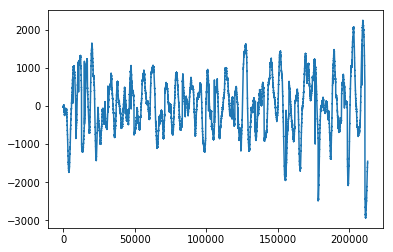

In [9]:
buf_len = 5000
bufread = moni.read_frames(buf_len)
time.sleep(buf_len*0.001)
time.sleep(0.5)
chunk = bufread.read_formatted()
plt.plot(chunk)
print(rms(chunk))
print(np.std(chunk))
print(mad(chunk))

In [12]:
moni.rms_thresh

nan

/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


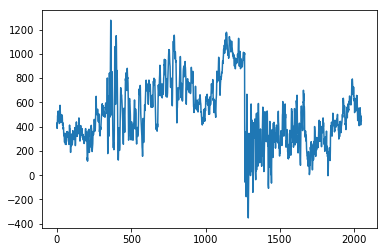

In [17]:
plt.plot(unpack_bits(a, np.int16, 1))

In [21]:
moni.stream_buffer.read_formatted()

/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


array([], dtype=int16)

/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


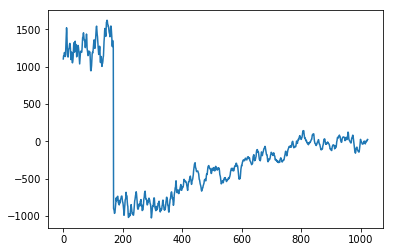

In [23]:
plt.plot(unpack_bits(moni._stream.read(moni.frames_per_buffer), np.int16, 1))

In [ ]:
moni.stop_triggered_mode()

In [ ]:
moni.stop_triggered_mode()

In [ ]:
moni.record_epoch_max_elem

In [ ]:
def interrupt_wrapper(func):
        

In [ ]:
import glob
import os
glob.glob()